In [1]:
!git clone https://github.com/Acciorocketships/sae.git

Cloning into 'sae'...
remote: Enumerating objects: 662, done.
remote: Counting objects: 100% (662/662), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 662 (delta 392), reused 641 (delta 376), pack-reused 0 (from 0)
Receiving objects: 100% (662/662), 20.79 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (392/392), done.


In [2]:
%cd sae

/content/sae


In [ ]:
!pip install -e


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [3]:
import torch
from torch import nn, optim


In [4]:
from sae import AutoEncoder

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [6]:
class GeneInteractionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GeneInteractionNN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
#Autoencoder being trained for each gene across all individuals (each batch is a different ind)
#####THIS ONE IS ONE SYNTHETIC DATA WITH TWO DIFFERENT DISTRIBUTIONS -- FOR THE SAME DATA AS THE OTHER FRAMEWORK PLEASE SCROLL DOWN
import torch
from sae import AutoEncoder
from sklearn.preprocessing import StandardScaler


num_individuals = 30
num_genes = 15         #Number of genes per individual
max_n = 200           #Max input dimension for each gene (discuss later)
embedding_dim = 4     #latent space dimension
epochs = 100

# 1. Generating synthetic data in which each class has a different distribution
group_0 = torch.normal(mean=1, std=0.4, size=(15, num_genes, max_n))
group_1 = torch.normal(mean=1.5, std=0.3, size=(15, num_genes, max_n))

data = torch.cat((group_0, group_1), dim=0)
labels = torch.cat((torch.zeros(15), torch.ones(15)))


data_scaled = torch.empty_like(data)
scaler = StandardScaler()
for gene_idx in range(num_genes):
    gene_data = data[:, gene_idx, :]  # Shape: (30, max_n)
    data_scaled[:, gene_idx, :] = torch.tensor(
        scaler.fit_transform(gene_data), dtype=torch.float32
    )

#place holder for final embeddings: (num_individuals, num_genes * embedding_dim)
final_embeddings = torch.empty((num_individuals, num_genes * embedding_dim))

# 2. Training AutoEncoder for each gene
for gene_idx in range(num_genes):
    print(f"Training autoencoder for Gene {gene_idx + 1}/{num_genes}")

    gene_data = data_scaled[:, gene_idx, :]

    model = AutoEncoder(dim=max_n, hidden_dim=embedding_dim, max_n=max_n)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    batch = torch.arange(0, num_individuals)

    #Training autoencoder
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        #forward
        _, batchr = model(gene_data, batch)
        loss = model.loss()["loss"]

        #backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    #extracting latent embeddings for the current gene
    model.eval()
    with torch.no_grad():
        z = model.encoder(gene_data, batch)  #shape: (num_individuals, embedding_dim)


    final_embeddings[:, gene_idx * embedding_dim:(gene_idx + 1) * embedding_dim] = z


print("Final Embeddings Shape:", final_embeddings.shape)


Training autoencoder for Gene 1/15
Epoch 10/100, Loss: 0.3960404694080353


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 20/100, Loss: 0.35335826873779297
Epoch 30/100, Loss: 0.31316134333610535
Epoch 40/100, Loss: 0.27566424012184143
Epoch 50/100, Loss: 100.77806091308594
Epoch 60/100, Loss: 79.06385803222656
Epoch 70/100, Loss: 66.37223052978516
Epoch 80/100, Loss: 63.674415588378906
Epoch 90/100, Loss: 62.52069854736328
Epoch 100/100, Loss: 61.6512565612793
Training autoencoder for Gene 2/15
Epoch 10/100, Loss: 0.30938199162483215
Epoch 20/100, Loss: 0.27877411246299744
Epoch 30/100, Loss: 108.59234619140625
Epoch 40/100, Loss: 100.84932708740234
Epoch 50/100, Loss: 85.40225219726562
Epoch 60/100, Loss: 66.30450439453125
Epoch 70/100, Loss: 63.19626235961914
Epoch 80/100, Loss: 61.25282287597656
Epoch 90/100, Loss: 58.87060546875
Epoch 100/100, Loss: 58.77933883666992
Training autoencoder for Gene 3/15
Epoch 10/100, Loss: 114.65299224853516
Epoch 20/100, Loss: 90.00298309326172
Epoch 30/100, Loss: 82.51826477050781
Epoch 40/100, Loss: 78.42537689208984
Epoch 50/100, Loss: 71.60430145263672
Epoch

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(final_embeddings.detach().numpy(), labels.numpy(), test_size=0.2, random_state=42)

In [ ]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [ ]:
#The MLP part
input_dim = final_embeddings.shape[1]
hidden_dim = 12
model = GeneInteractionNN(input_dim, hidden_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

Epoch 10/100, Loss: 0.46882691979408264
Epoch 20/100, Loss: 0.29003143310546875
Epoch 30/100, Loss: 0.19289427995681763
Epoch 40/100, Loss: 0.1378091722726822
Epoch 50/100, Loss: 0.10305505245923996
Epoch 60/100, Loss: 0.07706446200609207
Epoch 70/100, Loss: 0.057174187153577805
Epoch 80/100, Loss: 0.04312387481331825
Epoch 90/100, Loss: 0.03346600756049156
Epoch 100/100, Loss: 0.02675621025264263


In [ ]:
#Testing
model.eval()
with torch.no_grad():
    y_pred_test = model(x_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.022545374929904938


In [ ]:
#Rounding probabilities into 0 and 1 to compute accuracy, precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predicted_classes = (y_pred_test > 0.5).int()

y_true = y_test.squeeze().numpy()
y_pred = predicted_classes.squeeze().numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [ ]:
y_pred_test

tensor([[0.9806],
        [0.9946],
        [0.9910],
        [0.9942],
        [0.0293],
        [0.0635]])

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy

In [10]:
#To read the synthetic data
import scanpy as sc
adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/processed_dataset_16genes.h5ad")

In [11]:
import pandas as pd
phenotype_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phenotypes_16gene.csv')

In [12]:
phenotype_df.rename(columns={'Sample_ID': 'subject_id'}, inplace=True)

In [13]:
adata.obs['subject_id'] = adata.obs['subject_id'].astype(int)

In [14]:
adata.obs = adata.obs.merge(phenotype_df, on='subject_id', how='left')

In [15]:
unique_subjects = adata.obs.groupby('subject_id')['binary_y'].unique()

In [16]:
for subject_id, binary_y_values in unique_subjects.items(): print(f'Subject ID: {subject_id}, Binary Y: {binary_y_values}')

Subject ID: 1, Binary Y: [1]
Subject ID: 2, Binary Y: [0]
Subject ID: 3, Binary Y: [1]
Subject ID: 4, Binary Y: [0]
Subject ID: 5, Binary Y: [0]
Subject ID: 6, Binary Y: [0]
Subject ID: 7, Binary Y: [0]
Subject ID: 8, Binary Y: [1]
Subject ID: 9, Binary Y: [0]
Subject ID: 10, Binary Y: [0]
Subject ID: 11, Binary Y: [0]
Subject ID: 12, Binary Y: [0]
Subject ID: 13, Binary Y: [0]
Subject ID: 14, Binary Y: [1]
Subject ID: 15, Binary Y: [0]
Subject ID: 16, Binary Y: [1]
Subject ID: 17, Binary Y: [0]
Subject ID: 18, Binary Y: [0]
Subject ID: 19, Binary Y: [0]
Subject ID: 20, Binary Y: [0]


In [18]:
#To perform on the adata above
from sklearn.preprocessing import StandardScaler
embedding_dim = 4  #latent space dimension
epochs = 100
n_max = 500        #maximum number of cells per gene for each individual

# 1.Extracting expression data and metadata
expression_data = adata.X.toarray()
subject_ids = adata.obs["subject_id"].values
phenotypes = adata.obs["binary_y"].values


n_individuals = len(set(subject_ids))
n_genes = expression_data.shape[1]

#To ensure correct phenotype order
labels = []
for individual_id in sorted(set(subject_ids)):
    labels.append(np.unique(phenotypes[adata.obs["subject_id"] == individual_id])[0])
labels = torch.tensor(labels, dtype=torch.float32)


#Placeholder for final embeddings: (n_individuals, n_genes * embedding_dim)
final_embeddings = torch.empty((n_individuals, n_genes * embedding_dim))



# 2. Processing each gene
for gene_idx in range(n_genes):
    print(f"Processing Gene {gene_idx + 1}/{n_genes}")
    current_gene_data = []

    for individual_id in sorted(set(subject_ids)):
        #Extracting cells for the current gene and individual
        individual_cells = expression_data[subject_ids == individual_id, gene_idx]


        if len(individual_cells) > n_max:
            individual_cells = individual_cells[:n_max]

        #To pad with zeros if fewer than n_max (?????????????should I do it? since I think it is okay for sets to have different length)
        padded_cells = torch.zeros(n_max)
        padded_cells[:len(individual_cells)] = torch.tensor(individual_cells, dtype=torch.float32)


        current_gene_data.append(padded_cells.unsqueeze(0))

    #to stack all individuals' data for the current gene
    current_gene_data = torch.cat(current_gene_data, dim=0)  # shape: (n_individuals, n_max)

    #Scaling for the current gene (should be like this or all scaled before????????????????)
    scaler = StandardScaler()
    current_gene_data = torch.tensor(scaler.fit_transform(current_gene_data), dtype=torch.float32)

    #initialization of autoencoder for the current gene
    model = AutoEncoder(dim=n_max, hidden_dim=embedding_dim, max_n=n_max)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    #batch indices for individuals
    batch = torch.arange(0, n_individuals)

    #Training
    torch.manual_seed(641555)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        #forard
        _, batchr = model(current_gene_data, batch)
        loss = model.loss()["loss"]

        #backward
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    #to extract latent embeddings for the current gene
    model.eval()
    with torch.no_grad():
        z = model.encoder(current_gene_data, batch)  # Shape: (n_individuals, embedding_dim)

    final_embeddings[:, gene_idx * embedding_dim:(gene_idx + 1) * embedding_dim] = z


print("Final Embeddings Shape:", final_embeddings.shape)


Processing Gene 1/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 0.4196726679801941
Epoch 20/100, Loss: 0.37868255376815796
Epoch 30/100, Loss: 0.33973145484924316
Epoch 40/100, Loss: 0.3030104637145996
Epoch 50/100, Loss: 0.26865044236183167


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 60/100, Loss: 3.078796863555908
Epoch 70/100, Loss: 2.3681817054748535
Epoch 80/100, Loss: 2.2808380126953125
Epoch 90/100, Loss: 2.1736786365509033
Epoch 100/100, Loss: 2.0781869888305664
Processing Gene 2/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.7738698720932007
Epoch 20/100, Loss: 1.7124788761138916
Epoch 30/100, Loss: 1.6508716344833374
Epoch 40/100, Loss: 1.5894529819488525
Epoch 50/100, Loss: 1.5284219980239868
Epoch 60/100, Loss: 1.4678926467895508
Epoch 70/100, Loss: 1.4079617261886597
Epoch 80/100, Loss: 1.3487228155136108
Epoch 90/100, Loss: 1.2902724742889404
Epoch 100/100, Loss: 1.2327101230621338
Processing Gene 3/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.6786295175552368
Epoch 20/100, Loss: 1.6092067956924438
Epoch 30/100, Loss: 1.5409666299819946
Epoch 40/100, Loss: 1.4730186462402344
Epoch 50/100, Loss: 1.4056642055511475
Epoch 60/100, Loss: 1.339032769203186
Epoch 70/100, Loss: 1.273248314857483
Epoch 80/100, Loss: 1.2084264755249023
Epoch 90/100, Loss: 1.144680142402649
Epoch 100/100, Loss: 1.0821192264556885
Processing Gene 4/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 2.2635061740875244
Epoch 20/100, Loss: 1.6364902257919312
Epoch 30/100, Loss: 1.5718129873275757
Epoch 40/100, Loss: 1.5032906532287598
Epoch 50/100, Loss: 1.434208869934082
Epoch 60/100, Loss: 1.3656307458877563
Epoch 70/100, Loss: 1.297926664352417
Epoch 80/100, Loss: 1.231266975402832
Epoch 90/100, Loss: 1.1657636165618896
Epoch 100/100, Loss: 1.101517677307129
Processing Gene 5/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.6703050136566162
Epoch 20/100, Loss: 1.6015784740447998
Epoch 30/100, Loss: 1.533276915550232
Epoch 40/100, Loss: 1.4655182361602783
Epoch 50/100, Loss: 1.3984181880950928
Epoch 60/100, Loss: 1.332089900970459
Epoch 70/100, Loss: 1.2666406631469727
Epoch 80/100, Loss: 1.202176809310913
Epoch 90/100, Loss: 1.1388018131256104
Epoch 100/100, Loss: 1.0766170024871826
Processing Gene 6/16
Epoch 10/100, Loss: 1.8740612268447876


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 20/100, Loss: 1.819695234298706
Epoch 30/100, Loss: 1.7658361196517944
Epoch 40/100, Loss: 1.7120122909545898
Epoch 50/100, Loss: 1.6582467555999756
Epoch 60/100, Loss: 1.6046168804168701
Epoch 70/100, Loss: 1.5512102842330933
Epoch 80/100, Loss: 1.4981205463409424
Epoch 90/100, Loss: 1.4454418420791626
Epoch 100/100, Loss: 1.3932713270187378
Processing Gene 7/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.6704305410385132
Epoch 20/100, Loss: 1.6012239456176758
Epoch 30/100, Loss: 1.5325982570648193
Epoch 40/100, Loss: 1.4645700454711914
Epoch 50/100, Loss: 1.3972463607788086
Epoch 60/100, Loss: 1.3307311534881592
Epoch 70/100, Loss: 1.2651269435882568
Epoch 80/100, Loss: 1.2005339860916138
Epoch 90/100, Loss: 1.1370527744293213
Epoch 100/100, Loss: 1.0747833251953125
Processing Gene 8/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.6711947917938232
Epoch 20/100, Loss: 1.6013637781143188
Epoch 30/100, Loss: 1.5329160690307617
Epoch 40/100, Loss: 1.4650394916534424
Epoch 50/100, Loss: 1.3978416919708252
Epoch 60/100, Loss: 1.3314317464828491
Epoch 70/100, Loss: 1.2659145593643188
Epoch 80/100, Loss: 1.2013938426971436
Epoch 90/100, Loss: 1.1379718780517578
Epoch 100/100, Loss: 1.075749158859253
Processing Gene 9/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.773400068283081
Epoch 20/100, Loss: 1.7652534246444702
Epoch 30/100, Loss: 1.7076332569122314
Epoch 40/100, Loss: 1.6499792337417603
Epoch 50/100, Loss: 1.5925753116607666
Epoch 60/100, Loss: 1.5355145931243896
Epoch 70/100, Loss: 1.478797197341919
Epoch 80/100, Loss: 1.4225585460662842
Epoch 90/100, Loss: 1.3668978214263916
Epoch 100/100, Loss: 1.311919927597046
Processing Gene 10/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.727140188217163
Epoch 20/100, Loss: 1.663393259048462
Epoch 30/100, Loss: 1.5993868112564087
Epoch 40/100, Loss: 1.5355117321014404
Epoch 50/100, Loss: 1.472017526626587
Epoch 60/100, Loss: 1.409062385559082
Epoch 70/100, Loss: 1.3467719554901123
Epoch 80/100, Loss: 1.28525972366333
Epoch 90/100, Loss: 1.224632978439331
Epoch 100/100, Loss: 1.16499662399292
Processing Gene 11/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.7218058109283447
Epoch 20/100, Loss: 1.6560437679290771
Epoch 30/100, Loss: 1.5908753871917725
Epoch 40/100, Loss: 1.5262064933776855
Epoch 50/100, Loss: 1.4621213674545288
Epoch 60/100, Loss: 1.3987044095993042
Epoch 70/100, Loss: 1.336043119430542
Epoch 80/100, Loss: 1.274228811264038
Epoch 90/100, Loss: 1.2133572101593018
Epoch 100/100, Loss: 1.1535266637802124
Processing Gene 12/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.6703193187713623
Epoch 20/100, Loss: 1.6013996601104736
Epoch 30/100, Loss: 1.5329158306121826
Epoch 40/100, Loss: 1.4649977684020996
Epoch 50/100, Loss: 1.3977611064910889
Epoch 60/100, Loss: 1.331315279006958
Epoch 70/100, Loss: 1.2657657861709595
Epoch 80/100, Loss: 1.2012165784835815
Epoch 90/100, Loss: 1.1377698183059692
Epoch 100/100, Loss: 1.0755268335342407
Processing Gene 13/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.721121072769165
Epoch 20/100, Loss: 1.6560001373291016
Epoch 30/100, Loss: 1.5912107229232788
Epoch 40/100, Loss: 1.526841640472412
Epoch 50/100, Loss: 1.462988018989563
Epoch 60/100, Loss: 1.3997459411621094
Epoch 70/100, Loss: 1.3372142314910889
Epoch 80/100, Loss: 1.275493860244751
Epoch 90/100, Loss: 1.2146857976913452
Epoch 100/100, Loss: 1.0776408910751343
Processing Gene 14/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.670336365699768
Epoch 20/100, Loss: 1.6015760898590088
Epoch 30/100, Loss: 1.5332634449005127
Epoch 40/100, Loss: 1.4654967784881592
Epoch 50/100, Loss: 1.398390293121338
Epoch 60/100, Loss: 1.332056999206543
Epoch 70/100, Loss: 1.2666032314300537
Epoch 80/100, Loss: 1.202135682106018
Epoch 90/100, Loss: 1.1387571096420288
Epoch 100/100, Loss: 1.0765697956085205
Processing Gene 15/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.670692801475525
Epoch 20/100, Loss: 1.6014978885650635
Epoch 30/100, Loss: 1.5327601432800293
Epoch 40/100, Loss: 1.4646713733673096
Epoch 50/100, Loss: 1.3972933292388916
Epoch 60/100, Loss: 1.3307337760925293
Epoch 70/100, Loss: 1.2650907039642334
Epoch 80/100, Loss: 1.2004634141921997
Epoch 90/100, Loss: 1.1369515657424927
Epoch 100/100, Loss: 1.0746541023254395
Processing Gene 16/16


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/content/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Reduc

Epoch 10/100, Loss: 1.6703145503997803
Epoch 20/100, Loss: 1.6015806198120117
Epoch 30/100, Loss: 1.5332773923873901
Epoch 40/100, Loss: 1.4655174016952515
Epoch 50/100, Loss: 1.3984166383743286
Epoch 60/100, Loss: 1.332087516784668
Epoch 70/100, Loss: 1.266637921333313
Epoch 80/100, Loss: 1.2021733522415161
Epoch 90/100, Loss: 1.1387979984283447
Epoch 100/100, Loss: 1.0766133069992065
Final Embeddings Shape: torch.Size([20, 64])


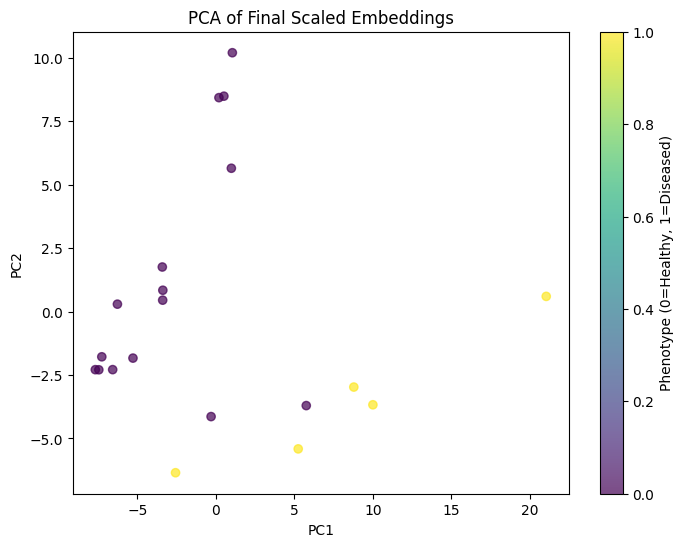

In [20]:
#PCA Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
final_embeddings_pca = pca.fit_transform(final_embeddings.numpy())
plt.figure(figsize=(8, 6))
plt.scatter(final_embeddings_pca[:, 0], final_embeddings_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Phenotype (0=Healthy, 1=Diseased)')
plt.title('PCA of Final Scaled Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [21]:
#Train and testing preparation
x_train, x_test, y_train, y_test = train_test_split(final_embeddings.detach().numpy(), labels.numpy(), test_size=0.2, random_state=1055)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [22]:
import random

#To set random seeds for reproducibility
def set_random_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seeds(seed=42)

In [25]:
#The MLP part
input_dim = final_embeddings.shape[1]
hidden_dim = 12
model = GeneInteractionNN(input_dim, hidden_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

Epoch 10/100, Loss: 0.6179172396659851
Epoch 20/100, Loss: 0.532920241355896
Epoch 30/100, Loss: 0.49231481552124023
Epoch 40/100, Loss: 0.44925710558891296
Epoch 50/100, Loss: 0.40691035985946655
Epoch 60/100, Loss: 0.3642832934856415
Epoch 70/100, Loss: 0.3224434554576874
Epoch 80/100, Loss: 0.2842382490634918
Epoch 90/100, Loss: 0.249783456325531
Epoch 100/100, Loss: 0.2196149230003357


In [27]:
#Testing
model.eval()
with torch.no_grad():
    y_pred_test = model(x_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.1784927397966385


In [28]:
#Rounding probabilities into 0 and 1 to compute accuracy, precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predicted_classes = (y_pred_test > 0.5).int()


y_true = y_test.squeeze().numpy()
y_pred = predicted_classes.squeeze().numpy()


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
